In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython import display
from scipy.stats import norm
%matplotlib inline
slim = tf.contrib.slim
NormalDiag = tf.contrib.distributions.MultivariateNormalDiag

# Log-Probability

In [2]:
def log_normal_diag(x, mu, logvar):
    residuals = x - mu
    weighted_squares = (residuals ** 2) / (2 * tf.exp(logvar))
    normalization = 0.5 * (tf.log(2 * np.pi) + logvar)
    ll = -(weighted_squares + normalization)
    return tf.reduce_mean(tf.reduce_sum(ll, 1))

# Inverse Autoregressive Flow

In [105]:
def ar_masks(z_size, h_size, shape=[256, 256]):
    
    masks = []
    
    n_in = h_size + z_size
    id_in = np.concatenate(([-1 for _ in range(h_size)], range(z_size)))
    
    for m in range(len(shape)):
        
        n_out = shape[m]
        id_out = np.random.randint(0, z_size - 1, size=n_out) 
        mask = np.zeros([n_in, n_out], dtype=np.float32)
        for k_in in range(n_in):
            for k_out in range(n_out):
                if id_out[k_out] >= id_in[k_in]:
                    mask[k_in, k_out] = 1
        masks.append(mask)
        
        n_in = n_out
        id_in = id_out
        
    n_out = 2 * z_size
    id_out = np.concatenate((range(z_size), range(z_size)))
    mask = np.zeros([n_in, n_out], dtype=np.float32)        
    for k_in in range(n_in):
        for k_out in range(n_out):
            if id_out[k_out] > id_in[k_in]:
                mask[k_in, k_out] = 1
    masks.append(mask)

    return masks

def ar_layer(x, mask):
    
    W = tf.Variable(tf.truncated_normal(mask.shape, stddev=0.1))
    W = tf.mul(W, mask)
    b = tf.Variable(tf.constant(0., shape=[mask.shape[1],]))
    
    return tf.matmul(x, W) + b

def ar_net(z_init, z_size, h, h_size, shape=[256, 256]):
    
    masks = ar_masks(z_size, h_size, shape)
    hidden = tf.concat(values=[h, z_init], concat_dim=1)
    
    for i in range(len(shape)):
        hidden = tf.nn.elu(ar_layer(hidden, masks[i]))
    
    hidden = ar_layer(hidden, masks[len(shape)])
    
    s = hidden[:, :z_size]
    m = hidden[:, z_size:]
        
    return s, m

# IAF VAE

In [212]:
# IAF z
class IAFVAE:
    
    def __init__(self, x_size, z_size, h_size, N=1):
                
        self.x = tf.placeholder(tf.float32, [None, x_size])
        self.x_N = tf.tile(self.x, [N, 1])
        self.lr = tf.constant(0.001)

        # Recognition Model q(z|x)
        rec = slim.stack(self.x_N, slim.fully_connected, [128])
        mu_z0 = slim.fully_connected(rec, z_size, activation_fn=None)
        logvar_z0 = slim.fully_connected(rec, z_size, activation_fn=None)
        h = slim.fully_connected(rec, h_size, activation_fn=None)
        
        # Sampling N times
        epsilon = tf.random_normal(tf.shape(logvar_z0))
        z_temp = mu_z0 + tf.exp(logvar_z0) * epsilon
        
        # Normalizing flow
        m, s = ar_net(z_temp, z_size, h, h_size, shape=[128])
        var_f0 = tf.nn.sigmoid(s)
        z_temp = (1 - var_f0) * m + var_f0 * z_temp
        z_temp = tf.reverse(z_temp, [False, True])
        
        m, s = ar_net(z_temp, z_size, h, h_size, shape=[128])
        var_f1 = tf.nn.sigmoid(s)
        z_temp = (1 - var_f1) * m + var_f1 * z_temp
        
        self.z = z_temp
        
        # Generative model p(x|y) with constant variance over all dimensions
        gen = slim.stack(slim.flatten(self.z), slim.fully_connected, [128])
        mu_x = slim.fully_connected(gen, x_size, activation_fn=None)
        logvar_x = tf.zeros_like(mu_x) + tf.Variable(tf.random_normal((1,), stddev=0.001)) ** 2

        # ELBO
        self.log_p_x = log_normal_diag(self.x_N, mu_x, logvar_x)
        self.log_p_z = log_normal_diag(self.z, tf.zeros_like(mu_z0), tf.zeros_like(logvar_z0))
        
        self.flow = tf.reduce_mean(tf.reduce_sum(tf.log(var_f0 + 1e-5), 1)) + tf.reduce_mean(tf.reduce_sum(tf.log(var_f1 + 1e-5), 1))
        
        self.log_q_z = log_normal_diag(epsilon, tf.zeros_like(mu_z0), tf.zeros_like(logvar_z0)) \
                       - tf.reduce_mean(tf.reduce_sum(logvar_z0, 1)) - self.flow
        self.ELBO = self.log_p_x + self.log_p_z - self.log_q_z
        self.loss = -self.ELBO
                        
        # Optimizer
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss, 
                                                                               var_list=slim.get_model_variables())
        
        # Session
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())
        
    def train(self, x_batch, lr):
        
        _, px, pz, qz, fl = self.sess.run([self.train_op, self.log_p_x, self.log_p_z, self.log_q_z, self.flow], 
                                          feed_dict={self.x:x_batch, self.lr:current_lr})
            
        return px, pz, qz, fl
    
    def get_x(self, z_sample):
        
        return self.sess.run(self.p_x.mean(), feed_dict={self.z: z_sample})
    
    def get_z(self, x_sample):
        
        return self.sess.run(self.z, feed_dict={self.x: x_sample})

# Training

In [213]:
toy_data = np.asarray([[0.01, 0.01, 0.01, 0.01, 0.01, 1.0], [0.01,0.01, 0.01, 0.01, 1.0, 0.01], [0.01, 0.01, 0.01, 1.0, 0.01, 0.01], [0.01, 0.01, 1.0, 0.01, 0.01, 0.01], [0.01, 1.0, 0.01, 0.01, 0.01, 0.01], [1.0, 0.01, 0.01, 0.01, 0.01, 0.01]]) * 3
toy_label = np.asarray([[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 0, 1, 0]])

z_size = 2
h_size = 50
x_size = toy_data.shape[1]

current_lr = 0.001

vae = IAFVAE(x_size, z_size, h_size, 50)

steps = []
p_x = []
p_z = []
q_z = []
f_l = []

In [214]:
if len(steps) > 0:
    i = steps[-1]
else:
    i = 0

while i < 200000:
    i += 1
    
    px, pz, qz, fl = vae.train(toy_data, current_lr)
    
    if i % 10 == 1:
        steps.append(i)
        p_x.append(px)
        p_z.append(pz)
        q_z.append(qz)
        f_l.append(fl)
        
    if i % 1000 == 1:
        #current_lr *= 0.9  
        
        f, ax = plt.subplots(2, 2, figsize=(15, 10))
        ax[0, 0].plot(steps, p_x)
        ax[0, 0].set_title("log p(x)")
        ax[0, 0].set_ylim(-10, 0)
        ax[0, 1].plot(steps, p_z)
        ax[0, 1].set_title("log p(z)")
        ax[0, 1].set_ylim(-4, -2)
        ax[1, 0].plot(steps, q_z)
        ax[1, 0].set_title("log q(z)")
        ax[1, 0].set_ylim(-3, -0)
        ax[1, 1].plot(steps, f_l)
        ax[1, 1].set_title("log flow")
        plt.show()

        display.display(plt)
        display.clear_output(wait=True)

KeyboardInterrupt: 

# Visualize Latent Space

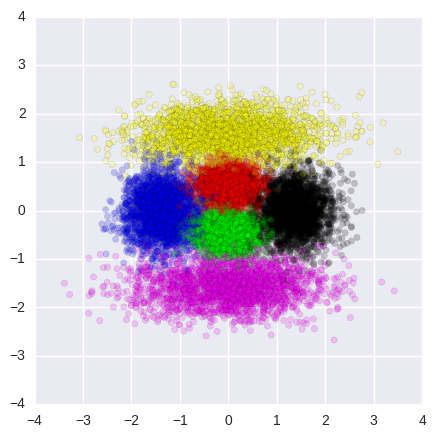

In [215]:
x = np.repeat(toy_data, [50], axis=0)
y = np.repeat(toy_label, [50], axis=0)

z = vae.get_z(x)

# Plot the latent representations
cm = plt.cm.get_cmap('RdYlBu')
plt.figure(figsize=(5, 5)) 
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.scatter(z[:, 0], z[:, 1], c=y, alpha=0.2, cmap=cm)

plt.savefig("zero_layer", dpi=600, facecolor='none')
plt.show()